---
title: Linear Convection
suptitle: Linear Convection with JAX
short_title: Linear Convection
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

* Jax-ify
* Don't Reinvent the Wheel

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".home"])

# append to path
sys.path.append(str(root))

Let's start with a simple 2D Linear Advection scheme. This PDE is defined as:

```{math}
:label: pde
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0
```

For the PDE {eq}`pde`, we are going to do a forward difference discretization in space and a backwards in time. It is given by:

```{math}
:label: discretization_full
u_{i,j}^{n+1} = u_{i,j}^{n} - c \frac{\Delta t}{\Delta x}\left( u_{i,j}-u_{i-1,j}^n \right)
```

Citation [cite](dot:10.1175/JTECH-D-20-0104.1).

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import serket as sk
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import wandb

sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# defime some variables

tmax, xmax = 0.5, 2.0
nt, nx = 151, 50
c = 0.5
dt, dx = tmax/(nt - 1), xmax/(nx - 1)

x_grid = np.linspace(0, 2., nx)


Steps:

1. Calculate the RHS
2. Apply the Boundary Conditions


In [4]:
# initialize field to be zero
def init_u(nx, dx):
    
    u = jnp.ones((nx,), dtype=jnp.float64)
    u = u.at[int(.5 / dx):int(1 / dx + 1)].set(2.0)
    
    return u

import kernex as kex
@kex.kmap(kernel_size=(2,), padding="valid", relative=True)
def fd_back(u, dx):
    return (u[1] - u[0]) / dx

def bc_fn(u):
    
    u = u.at[0].set(1.0)
    u = u.at[-1].set(1.0)
    return u

def rhs_fn(u, dx, c):
    # calculate rhs (backwads)
    u = jnp.pad(u, pad_width=((1,0)), mode="edge")
    rhs = - c * fd_back(u, dx)
    
    return rhs


def step_fn(u):
    
    # apply bcs
    u = bc_fn(u)
    
    # calculate RHS
    rhs = rhs_fn(u, dx, c)
    
    # time step
    u = u + dt * rhs
    
    return u

step_fn = jax.jit(step_fn)


# small sanity check
# assert (u[45:55, 45:55] > 1.8).all()

In [5]:
u_init = init_u(nx, dx)

u = u_init.copy()
for t in trange(nt + 1):
    
    u = step_fn(u)

2023-02-25 10:59:23.876776: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


  0%|          | 0/152 [00:00<?, ?it/s]

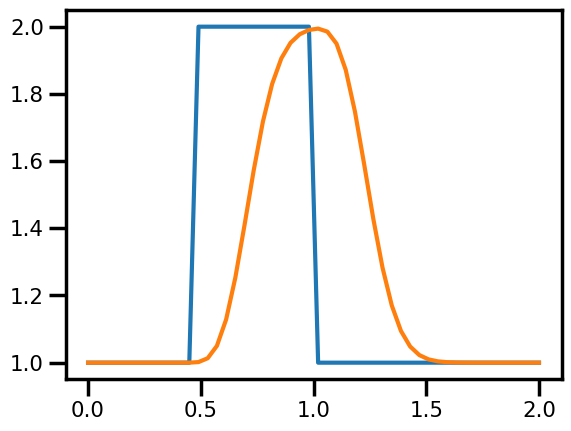

In [6]:
fig, ax = plt.subplots()
ax.plot(x_grid, u_init)
ax.plot(x_grid, u)
plt.show()

In [7]:

# initialize field to be zero
def init_u(nx, dx):
    
    u = jnp.ones((nx,), dtype=jnp.float64)
    u = u.at[int(.5 / dx):int(1 / dx + 1)].set(2.0)
    
    return u

import kernex as kex
@kex.kmap(kernel_size=(2,), padding="valid", relative=True)
def fd_back(u, dx):
    return (u[1] - u[0]) / dx

def bc_fn(u):
    
    u = u.at[0].set(1.0)
    u = u.at[-1].set(1.0)
    return u

def rhs_fn(u, dx, c):
    # calculate rhs (backwads)
    u = jnp.pad(u, pad_width=((1,0)), mode="edge")
    rhs = - c * fd_back(u, dx)

    # account for boundaries
    # rhs = u.at[1:].set(rhs)
    
    return rhs

In [8]:
from tqdm.notebook import tqdm

def vector_field(t, u, args):
    
    # calculate RHS
    rhs = rhs_fn(u, dx, c)
    
    # apply bcs
    u = bc_fn(u)
    
    return rhs

def stepper(u):
    
    u = u + dt * vector_field(None, u, None)
    
    return u

stepper = jax.jit(stepper)

# INITIALIZATION
u_init = init_u(nx, dx).copy()
u = u_init.copy()

for t in trange(nt + 1):
    
    u = stepper(u)

  0%|          | 0/152 [00:00<?, ?it/s]

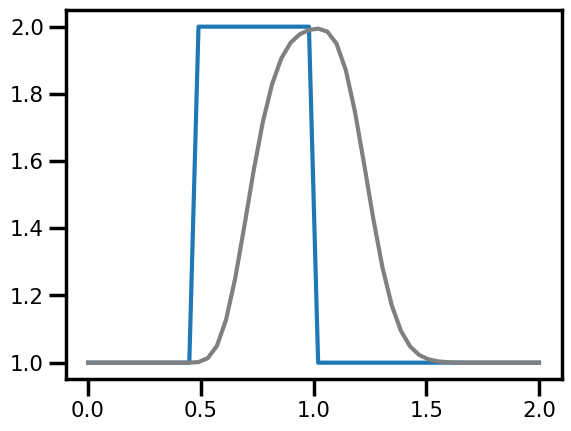

In [9]:
fig, ax = plt.subplots()
ax.plot(x_grid, u_init)
ax.plot(x_grid, u, color="gray")
plt.show()

In [10]:
import diffrax



# SPATIAL DISCRETIZATION
xmax = 2.0
nx = 50
c = 0.5
dx = xmax/(nx - 1)


# INITIAL CONDITION
u_init = init_u(nx, dx)

# define ODE
term = diffrax.ODETerm(vector_field)

# TEMPORAL DISCRETIZATION
t0 = 0
tmax = 0.5
nt = 150
dt = tmax/(nt - 1)
saveat = diffrax.SaveAt(ts=jnp.linspace(0, tmax, 10))

# TOLERANCES
rtol = 1e-10
atol = 1e-10
pcoeff = 0.3
icoeff = 0.4
dtmax = 0.001
stepsize_controller = diffrax.PIDController(
    pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=dtmax
)
solver = diffrax.Tsit5()
sol = diffrax.diffeqsolve(
    term,
    solver,
    t0,
    tmax,
    dt,
    u_init,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)



# stepsize_controller = diffrax.PIDController(
#     rtol=rtol, atol=atol
# )
# solver = diffrax.HalfSolver(diffrax.Heun())
# sol = diffrax.diffeqsolve(
#     term,
#     solver,
#     t0,
#     tmax,
#     dt,
#     u_init,
#     saveat=saveat,
#     stepsize_controller=stepsize_controller,
#     max_steps=None,
# )




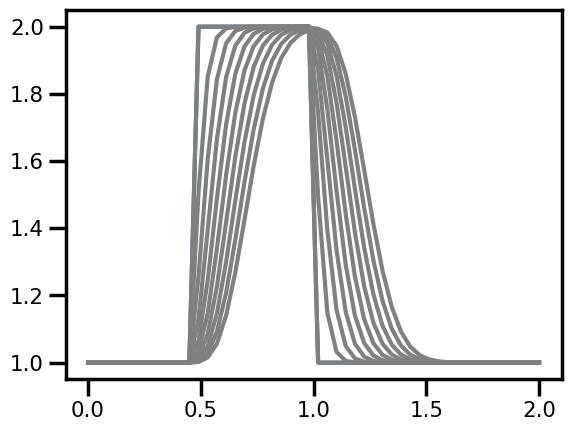

In [11]:
fig, ax = plt.subplots()
ax.plot(x_grid, u_init)
ax.plot(x_grid, sol.ys.T, color="gray")
plt.show()